k-space shape: (384, 512, 36)


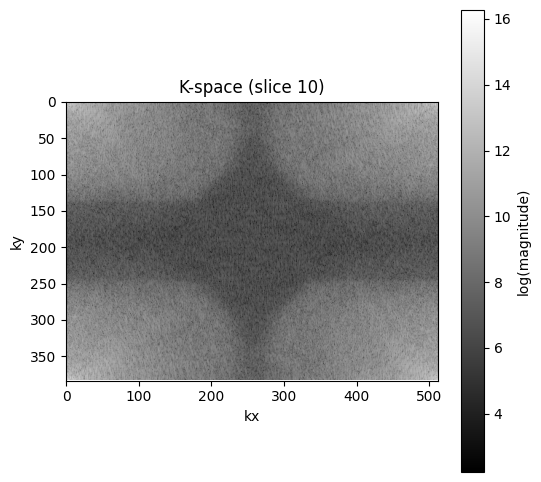

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ 데이터 로드
real = np.load('/home/mhb0917/의료영상처리/202255646/rawMRData_Real.npy')
imag = np.load('/home/mhb0917/의료영상처리/202255646/rawMRData_Imag.npy')

# 2️⃣ 복소수 데이터 생성
k_space = real + 1j * imag

# 3️⃣ 데이터 형태 확인
print("k-space shape:", k_space.shape)  # 예: (256, 256, 20) 형태 (가로, 세로, 슬라이스 수)

# 4️⃣ 임의의 슬라이스 인덱스 선택
slice_idx = 10  # 예시로 중간 슬라이스 선택
slice_kspace = k_space[:, :, slice_idx]

# 5️⃣ k-space 시각화 (log scale로 표현)
plt.figure(figsize=(6, 6))
plt.imshow(np.log1p(np.abs(np.fft.fftshift(slice_kspace))), cmap='gray')
plt.title(f'K-space (slice {slice_idx})')
plt.xlabel('kx')
plt.ylabel('ky')
plt.colorbar(label='log(magnitude)')
plt.grid(False)
plt.show()


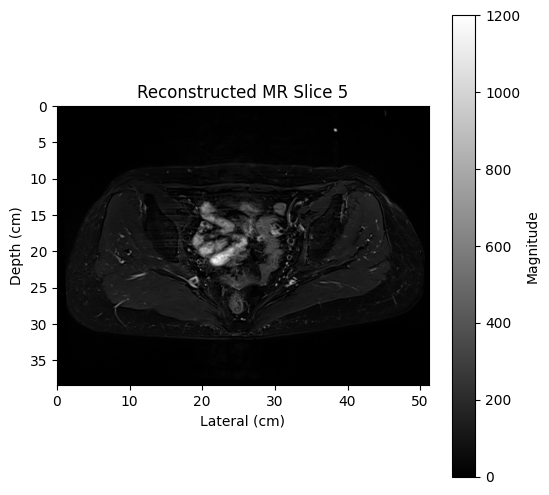

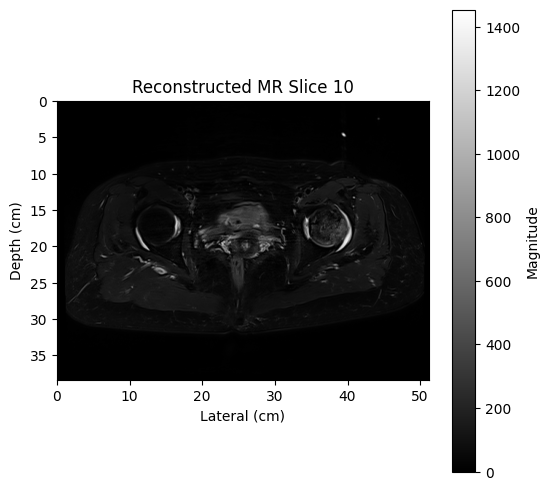

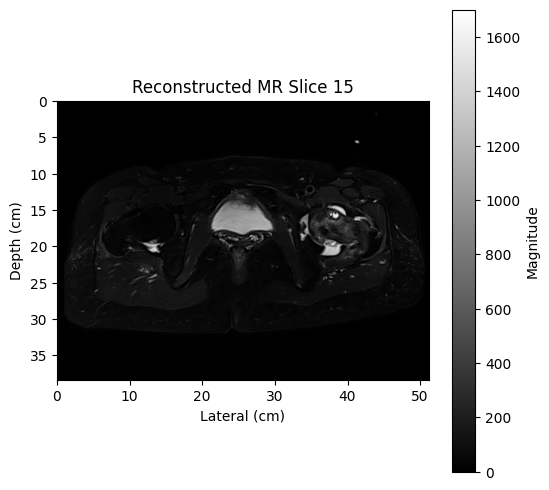

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import ifft2, fftshift

# 1️⃣ k-space 데이터 다시 로드 (이전 단계에서 사용했다면 생략 가능)
real = np.load('/home/mhb0917/의료영상처리/202255646/rawMRData_Real.npy')
imag = np.load('/home/mhb0917/의료영상처리/202255646/rawMRData_Imag.npy')
k_space = real + 1j * imag

# 2️⃣ 영상 재구성: 슬라이스별 2D inverse FFT 적용
image_space = np.zeros_like(k_space, dtype=np.complex64)
for i in range(k_space.shape[2]):
    shifted = fftshift(k_space[:, :, i])
    image_space[:, :, i] = ifft2(shifted)

# 3️⃣ 복원 영상: 절댓값 또는 실수부만 사용
magnitude_image = np.abs(image_space)

# 4️⃣ 축 단위 설정 (가정: 픽셀 간격이 0.1cm = 1mm)
pixel_spacing_x = 0.1  # cm
pixel_spacing_y = 0.1  # cm

nx, ny = magnitude_image.shape[:2]
x_axis = np.linspace(0, ny * pixel_spacing_x, ny)
y_axis = np.linspace(0, nx * pixel_spacing_y, nx)

# 5️⃣ 몇 개의 슬라이스 선택하여 시각화
selected_slices = [5, 10, 15]  # 원하는 슬라이스 인덱스 선택

for idx in selected_slices:
    plt.figure(figsize=(6, 6))
    plt.imshow(magnitude_image[:, :, idx], extent=[x_axis[0], x_axis[-1], y_axis[-1], y_axis[0]], cmap='gray')
    plt.title(f"Reconstructed MR Slice {idx}")
    plt.xlabel("Lateral (cm)")
    plt.ylabel("Depth (cm)")
    plt.colorbar(label="Magnitude")
    plt.grid(False)
    plt.show()


In [3]:
import os
import pydicom
from datetime import datetime

# 6️⃣ 저장된 magnitude_image를 직접 사용 (이전 코드와 연계)
# magnitude_image: shape (rows, cols, num_slices)

# DICOM 경로 설정
dicom_dir = '/home/mhb0917/의료영상처리/202255646/blind'
output_dir = '/home/mhb0917/의료영상처리/202255646/new_dicom'
os.makedirs(output_dir, exist_ok=True)

# 슬라이스 수 확인
num_slices = magnitude_image.shape[2]

# DICOM 파일 처리
for fname in sorted(os.listdir(dicom_dir)):
    if not fname.endswith('.dcm'):
        continue

    slice_index = int(os.path.splitext(fname)[0])  # 파일명에서 인덱스 추출
    if slice_index >= num_slices:
        print(f"⚠️ slice index {slice_index}는 범위를 초과합니다. 건너뜁니다.")
        continue

    # 원본 DICOM 로드
    dcm_path = os.path.join(dicom_dir, fname)
    ds = pydicom.dcmread(dcm_path)

    # 환자 정보 블라인드 여부 확인 (없어도 괜찮음)
    if hasattr(ds, 'PatientName') and ds.PatientName != '':
        print(f"⚠️ {fname}에서 환자 정보가 블라인드되지 않았습니다.")

    # 영상 데이터 정규화 (0~255) 및 uint8 변환
    img = magnitude_image[:, :, slice_index]
    img_norm = (img / np.max(img) * 255).astype(np.uint8)

    # DICOM에 삽입
    ds.Rows, ds.Columns = img_norm.shape
    ds.PixelData = img_norm.tobytes()
    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.BitsAllocated = 8
    ds.BitsStored = 8
    ds.HighBit = 7
    ds.PixelRepresentation = 0

    # 시간 정보 갱신 (옵션)
    now = datetime.now()
    ds.InstanceCreationDate = now.strftime('%Y%m%d')
    ds.InstanceCreationTime = now.strftime('%H%M%S')

    # 새로운 파일로 저장
    output_path = os.path.join(output_dir, fname)
    ds.save_as(output_path)

print(f"\n✅ 새로운 DICOM 파일들이 '{output_dir}'에 저장되었습니다. 이제 3D Slicer에서 불러올 수 있습니다.")


⚠️ 000000.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000001.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000002.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000003.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000004.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000005.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000006.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000007.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000008.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000009.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000010.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000011.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000012.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000013.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000014.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000015.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000016.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000017.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000018.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000019.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000020.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000021.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000022.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000023.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000024.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000025.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠️ 000026.dcm에서 환자 정보가 블라인드되지 않았습니다.
⚠